In [119]:
import tensorflow as tf
import os
import time
import itertools
import tensorflow_hub as hub
import keras

In [120]:
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(     # here we use the ImageDataGenerator
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,                # Applaying these all Data Augmentations
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [121]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [122]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [123]:
import cv2
import imghdr

In [124]:
data_dir = 'data' 


In [125]:
image_exts = ['jpeg','jpg','bmp', 'png']

In [126]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [127]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=100,     # Batch siz emeans at a time it takes 20
                                                     directory=data_dir,    # Here we put shuffle= True so tat model doesnt memorise order
                                                     shuffle=True,
                                                     target_size=(256,256),
                                                     class_mode='binary')

Found 185 images belonging to 2 classes.


In [128]:
import numpy as np
from matplotlib import pyplot as plt

In [130]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 185 files belonging to 2 classes.


In [131]:
data_iterator = data.as_numpy_iterator()

In [132]:
data_iterator

In [133]:
batch= data_iterator.next()

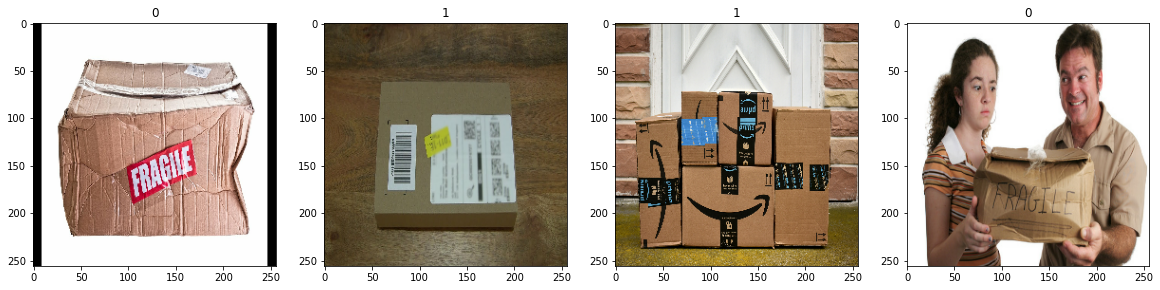

In [134]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [135]:
data = data.map(lambda x,y: (x/255, y))

In [136]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [137]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [138]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [140]:
model = Sequential()

In [141]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [142]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [143]:
logdir='logs'

In [144]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [145]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
4/4 [==============================] - 3s 399ms/step - loss: 2.3680 - accuracy: 0.4766 - val_loss: 0.6930 - val_accuracy: 0.5625
Epoch 2/40
4/4 [==============================] - 2s 374ms/step - loss: 0.7037 - accuracy: 0.4766 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 3/40
4/4 [==============================] - 2s 364ms/step - loss: 0.6883 - accuracy: 0.7578 - val_loss: 0.6809 - val_accuracy: 0.8750
Epoch 4/40
4/4 [==============================] - 2s 366ms/step - loss: 0.6809 - accuracy: 0.7344 - val_loss: 0.6479 - val_accuracy: 1.0000
Epoch 5/40
4/4 [==============================] - 2s 387ms/step - loss: 0.6461 - accuracy: 0.8047 - val_loss: 0.5831 - val_accuracy: 0.7188
Epoch 6/40
4/4 [==============================] - 2s 430ms/step - loss: 0.5842 - accuracy: 0.7266 - val_loss: 0.4769 - val_accuracy: 0.8125
Epoch 7/40
4/4 [==============================] - 2s 376ms/step - loss: 0.4832 - accuracy: 0.7812 - val_loss: 0.4290 - val_accuracy: 0.8438
Epoch 8/40
4/4 [====

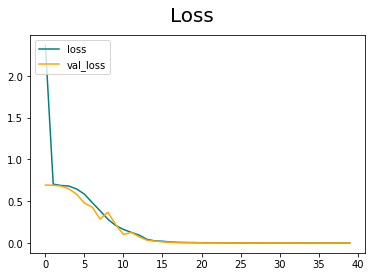

In [146]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

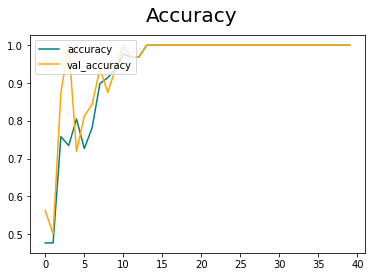

In [147]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [148]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [149]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [150]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 385ms/step


In [151]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [152]:
import cv2

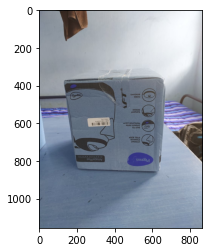

In [168]:
img = cv2.imread('packagetest/WhatsApp Image 2022-07-31 at 2.34.09 PM.jpeg')
plt.imshow(img)
plt.show()


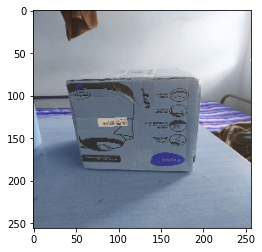

In [169]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [170]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 172ms/step


In [171]:
if yhat > 0.2: 
    print(f'Predicted class is Intact')
else:
    print(f'Predicted class is Damaged')

Predicted class is Intact


In [172]:
yhat

array([[0.9864928]], dtype=float32)